# Neutron - Reinforcement Learning

## Authors

* Filipe Barbosa - up201909573
* Hrvoje Maligec - up201911221
* José Pedro Baptista - up201705255

## Abstract

***TODO***

# 1. Introduction

In this project, we made a self-learning agent using reinforcement learning techniques that plays the Neutron board game. In order to implement said agent, we used Python, and OpenAi Gym, an open source library for developing and comparing reinforcement learning algorithms, as we were advised to.

### About the game

#### Name
Neutron

#### Basic knowledge
This game can be played in a 5x5 or 7x7 board.
There are two kinds of pieces, one for each player (e.g. blue and red), and the neutron.

#### Objective
The objective of this game is to bring the Neutron (N piece) to their home row/base (row where all the players pieces start) or to stalemate the opponent (preventing the opponent from playing their turn because of lack of options). 

#### Rules
The game starts with all blue pieces on Blue's home row and all red pieces on Red's home row, and the neutron in the center;
All pieces (including the neutron) move in a straight line horizontally, vertically, or diagonally, but they must move as far as they can go in the chosen direction. They can only move through or onto empty squares, and never past any piece;
Play begins with one player moving a piece from the home row. Thereafter on each turn, a player moves first the neutron and then one of his/her pieces.

#### Implementation Limitations
We don't support other boards other than the 5x5 one, due to the nature of this game and the way we are handling the different states. 

## 2. Description of the problem

### Game representation

#### Game State / Game Board
For state representation, we are using an integer matrix (array of arrays of integers), and each one of them can represent a Blue piece, Red piece, Neutron or an empty tile. 

#### Pieces
Each piece (or lack of) is represented by an integer value.

* Empty tile = 0
* Blue Piece = 1
* Red Piece = 2
* Neutron = 3

#### Moves
There are 8 possible move directions: Right, Left, Up, Down, Right-Up, Right-Down, Left-Up, Left-Down. In order to represent a move, we also need to specify the piece to apply the move to. So, our moves have the following representation:
(piece_to_move_x, piece_to_move_y, direction)


### What we needed to do
In order to make the self-learning agent with Open Ai gym, we decided to make our own, specialised environment. For that, we had to (between other things):

1. Define the observation and action spaces;
2. Allow different render modes (besides pygame), since it would slow the episodes down, and that isn't convenient while the agent is learning;
3. Incorporate CPU plays in the environment;
4. Implement a step function that returns the new state, the reward, and whether the game has ended or not, given a move.
After the environment was ready, we only had to implement the reinforcement learning algorithms to make the agent learn how to play neutron, given what the environment returned, after each action.

## 3. Approach

To implement the OpenAI Gym environment of the Neutron game, we used an [implementation we did for a previous projects](NeutronGame), that uses the Minimax algorithm for the CPU opponents. For the training, we use some of those bots as opponents for our learning bot.

Since the Neutron game board has a big number of possible states (*1.2356\*10<sup>10</sup>* for the 5x5 board), we had to something about how we stored them on the Q-table, so as not to overbear the memory. For that effect, we decided to start with an empty Q-table (for every algorithm) and only had a line for a state when that state was reached for the first time. Since the Q-table always starts with null (0) values for each action-state pair, we could just not include those cases in it. As soon as a state was reached, it is then added to the Q-table.

For the reward system, we decided ***CONTINUE***

We decided to implement the **Q-learning algorithm** and the **State-action-reward-state-action (SARSA) algorithm** to use in our reinforcement learning bot.

For both algorithms we implemented to different types of **Epsilon Decay**:

1. **Exponential Decay**: `epsilon = ending_epsilon + (starting_epsilon - ending_epsilon) * e^(-decay_rate * current_episode)`
2. **Linear Decay** (the decay stops when the ending_epsilon value is reached): `epsilon = starting_epsilon + (starting_epsilon - ending_epsilon) * (-decay_rate * current_episode)`


### 3.1. Q-learning

***TODO***

### 3.2. SARSA

***TODO***

## 4. Experimental Evaluation

### 4.1. Q-learning

***TODO***

Score over time: -0.15


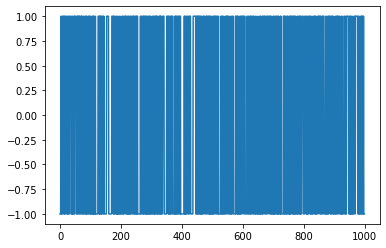

Time: 2.0685462951660156 seconds


In [5]:
import time
from NeutronRL.q_learning import QLearning
from NeutronRL.env_algorithm import EpsilonDecay
import matplotlib.pyplot as plt

start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Random-v0', log=False)
score, rewards, epsilon = qlearning.train()
print(f"Time: {time.time() - start_time} seconds")

winrate = []
num_wins = 0

for i in range(len(rewards)):
    if rewards[i] == 1:
        num_wins += 1

    winrate.append(num_wins / (i + 1))

plt.plot(winrate, label="Win Rate")
plt.plot(epsilons, label="Epsilon values")
plt.axhline(color="black", ls="--", alpha=0.4)
plt.ylim(-0.1, 1.1)
ax1.set_xlabel("Episodes")
plt.legend()
plt.show()

Score over time: -0.012


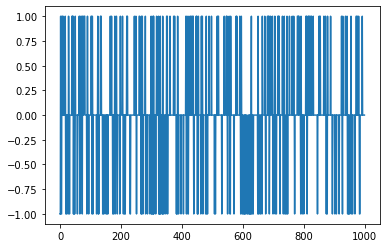

Time: 77.67914748191833 seconds


In [6]:
import time
from NeutronRL.q_learning import QLearning
from NeutronRL.env_algorithm import EpsilonDecay
import matplotlib.pyplot as plt

start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Random-v0', log=False)
score, rewards, epsilon = qlearning.train()

print(f"Time: {time.time() - start_time} seconds")

winrate = []
num_wins = 0

for i in range(len(rewards)):
    if rewards[i] == 1:
        num_wins += 1

    winrate.append(num_wins / (i + 1))

plt.plot(winrate, label="Win Rate")
plt.plot(epsilons, label="Epsilon values")
plt.axhline(color="black", ls="--", alpha=0.4)
plt.ylim(-0.1, 1.1)
ax1.set_xlabel("Episodes")
plt.legend()
plt.show()

Score over time: -0.696


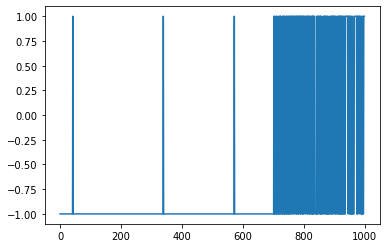

Time: 180.73934507369995 seconds


In [7]:
import time
from NeutronRL.q_learning import QLearning
from NeutronRL.env_algorithm import EpsilonDecay
import matplotlib.pyplot as plt

start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Exponential, env='Neutron-5x5-White-Easy-v0', log=False)
score, rewards, epsilon = qlearning.train()

print(f"Time: {time.time() - start_time} seconds")

winrate = []
num_wins = 0

for i in range(len(rewards)):
    if rewards[i] == 1:
        num_wins += 1

    winrate.append(num_wins / (i + 1))

plt.plot(winrate, label="Win Rate")
plt.plot(epsilons, label="Epsilon values")
plt.axhline(color="black", ls="--", alpha=0.4)
plt.ylim(-0.1, 1.1)
ax1.set_xlabel("Episodes")
plt.legend()
plt.show()

Score over time: -0.009


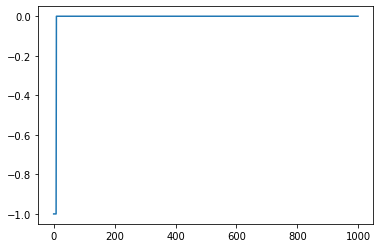

Time: 187.1882209777832 seconds


In [8]:
import time
from NeutronRL.q_learning import QLearning
from NeutronRL.env_algorithm import EpsilonDecay
import matplotlib.pyplot as plt

start_time = time.time()

qlearning = QLearning(max_episodes=1000, max_steps=2000, epsilon_decay=EpsilonDecay.Linear, env='Neutron-5x5-White-Easy-v0', log=False)
score, rewards, epsilon = qlearning.train()

print(f"Time: {time.time() - start_time} seconds")

winrate = []
num_wins = 0

for i in range(len(rewards)):
    if rewards[i] == 1:
        num_wins += 1

    winrate.append(num_wins / (i + 1))

plt.plot(winrate, label="Win Rate")
plt.plot(epsilons, label="Epsilon values")
plt.axhline(color="black", ls="--", alpha=0.4)
plt.ylim(-0.1, 1.1)
ax1.set_xlabel("Episodes")
plt.legend()
plt.show()

### 4.2. SARSA

***TODO***

## 5. Conclusions

***TODO***

## References

***TODO***